# Multi-Disease Classification

- Develop a multi-label classification model to classify different diseases based on the microorganisms in the gut microbiome.

## <font color='blue'>Import Libraries</font>

In [61]:
# Visualizations and Manipulations
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Problem Transformation
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

# Adapted
from skmultilearn.adapt import MLkNN
from scipy.sparse import lil_matrix

# Algorithms
from sklearn.naive_bayes import GaussianNB

# Model Training
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Evaluation Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

## <font color='blue'>Read Dataset</font>

In [2]:
# Read in and view the dataset
df = pd.read_csv('challenge_1_gut_microbiome_data.csv')
df.head()

,Unnamed: 0,Bacteria-1,Bacteria-2,Bacteria-3,Bacteria-4,Bacteria-5,Bacteria-6,Bacteria-7,Bacteria-8,Bacteria-9,...,Bacteria-1086,Bacteria-1087,Bacteria-1088,Bacteria-1089,Bacteria-1090,Bacteria-1091,Bacteria-1092,Bacteria-1093,Bacteria-1094,disease
0,Sample-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Disease-2
1,Sample-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,17111.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Disease-2
2,Sample-3,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Disease-2
3,Sample-4,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Disease-2
4,Sample-5,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1932.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,Disease-2


## <font color='blue'>Explore Dataset</font>

In [3]:
# Dimension of dataset
df.shape

(7481, 1096)

In [4]:
# Checking for duplicate rows
df.duplicated().sum()

0

In [5]:
# Checking for missing values
df.isnull().sum()

Unnamed: 0       0
Bacteria-1       0
Bacteria-2       0
Bacteria-3       0
Bacteria-4       0
                ..
Bacteria-1091    0
Bacteria-1092    0
Bacteria-1093    0
Bacteria-1094    0
disease          0
Length: 1096, dtype: int64

In [6]:
# Datatype information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7481 entries, 0 to 7480
Columns: 1096 entries, Unnamed: 0 to disease
dtypes: float64(1094), object(2)
memory usage: 62.6+ MB


- Will need to encode the objects to int

## <font color='blue'>Data Pre-Processing</font>

In [7]:
# Encoding the objects in sample columns
df['Unnamed: 0'] = df['Unnamed: 0'].str.replace('Sample-', '')
df['Unnamed: 0'] = df['Unnamed: 0'].astype(int)

df.dtypes

Unnamed: 0         int64
Bacteria-1       float64
Bacteria-2       float64
Bacteria-3       float64
Bacteria-4       float64
                  ...   
Bacteria-1091    float64
Bacteria-1092    float64
Bacteria-1093    float64
Bacteria-1094    float64
disease           object
Length: 1096, dtype: object

In [8]:
# Checking dataset again
df.head()

,Unnamed: 0,Bacteria-1,Bacteria-2,Bacteria-3,Bacteria-4,Bacteria-5,Bacteria-6,Bacteria-7,Bacteria-8,Bacteria-9,...,Bacteria-1086,Bacteria-1087,Bacteria-1088,Bacteria-1089,Bacteria-1090,Bacteria-1091,Bacteria-1092,Bacteria-1093,Bacteria-1094,disease
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Disease-2
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,17111.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Disease-2
2,3,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Disease-2
3,4,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Disease-2
4,5,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1932.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,Disease-2


In [9]:
print("disease")
print(df.disease.unique())

disease
['Disease-2' 'Disease-1' 'Disease-3' 'Healthy']


- The multiple labels are all included in one column of the dataset.
- We separate each label, 3 Disease types and Healthy into their own columns so the train and testing can be properly done on a multi-label dataset.

In [10]:
# Creating columns for multi-labels 

def categorise(row):  
    if row['disease'] == 'Disease-1':
        return '1'
    return '0'

df['Disease-1'] = df.apply(lambda row: categorise(row), axis=1)

def categorise(row):  
    if row['disease'] == 'Disease-2':
        return '1'
    return '0'

df['Disease-2'] = df.apply(lambda row: categorise(row), axis=1)

def categorise(row):  
    if row['disease'] == 'Disease-3':
        return '1'
    return '0'

df['Disease-3'] = df.apply(lambda row: categorise(row), axis=1)

def categorise(row):  
    if row['disease'] == 'Healthy':
        return '1'
    return '0'

df['Healthy'] = df.apply(lambda row: categorise(row), axis=1)


In [11]:
# Dropping the old column which included all labels together
df = df.drop(['disease'], axis=1)

# Encoding the created columns to integers
df = df.astype({"Disease-1": int, "Disease-2": int, "Disease-3": int, "Healthy": int})
df.head()

,Unnamed: 0,Bacteria-1,Bacteria-2,Bacteria-3,Bacteria-4,Bacteria-5,Bacteria-6,Bacteria-7,Bacteria-8,Bacteria-9,...,Bacteria-1089,Bacteria-1090,Bacteria-1091,Bacteria-1092,Bacteria-1093,Bacteria-1094,Disease-1,Disease-2,Disease-3,Healthy
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
2,3,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
3,4,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
4,5,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0,1,0,0


In [12]:
df.dtypes

Unnamed: 0         int64
Bacteria-1       float64
Bacteria-2       float64
Bacteria-3       float64
Bacteria-4       float64
                  ...   
Bacteria-1094    float64
Disease-1          int64
Disease-2          int64
Disease-3          int64
Healthy            int64
Length: 1099, dtype: object

- All datatypes are now floats/integers

## <font color='blue'>Feature Scaling</font>

In [26]:
features = df.iloc[:,:-4]
labels = df.iloc[:,[1095, 1096, 1097, 1098]]

# # Scaling each feature to a given range
scaler = MinMaxScaler()
scaledfeatures = scaler.fit_transform(features)

- Scaling was done on the feature data in order to correct for the variation in the sum of all the microorganisms in each sample.

In [27]:
features.head()

,Unnamed: 0,Bacteria-1,Bacteria-2,Bacteria-3,Bacteria-4,Bacteria-5,Bacteria-6,Bacteria-7,Bacteria-8,Bacteria-9,...,Bacteria-1085,Bacteria-1086,Bacteria-1087,Bacteria-1088,Bacteria-1089,Bacteria-1090,Bacteria-1091,Bacteria-1092,Bacteria-1093,Bacteria-1094
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,17111.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1932.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0


In [28]:
labels.head()

,Disease-1,Disease-2,Disease-3,Healthy
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


## <font color='blue'>Test and Train</font>

In [29]:
X = scaledfeatures
Y = labels

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3, random_state=23)

## <font color='blue'>Problem Transformation - Binary Relevance</font>

In [65]:
# Initializing
model_BR_GNB = BinaryRelevance(GaussianNB())

# Training
model_BR_GNB.fit(x_train,y_train)

# Predicting
y_pred_BR_GNB = model_BR_GNB.predict(x_test)

# Testing
BR_F1 = f1_score(y_test, y_pred_BR_GNB, average='micro')


## <font color='blue'>Problem Transformation - Classifier Chains</font>

In [54]:
# Initializing
model_CC_GNB = ClassifierChain(GaussianNB())

# Training
model_CC_GNB.fit(x_train,y_train)

# Predicting
y_pred_CC_GNB = model_CC_GNB.predict(x_test)

# Testing
CC_F1 = f1_score(y_test,y_pred_CC_GNB, average='micro')

## <font color='blue'>Problem Transformation - Label Powerset</font>

In [55]:
# Initializing
model_LP_GNB = LabelPowerset(GaussianNB())

# Training
model_LP_GNB.fit(x_train,y_train)

# Predicting
y_pred_LP_GNB = model_LP_GNB.predict(x_test)

# Testing
LP_F1 = f1_score(y_test,y_pred_LP_GNB, average='micro')

## <font color='blue'>Adapted Algorithm</font>

In [56]:
# Initializing
model_AA = MLkNN(k=20)

x_train = lil_matrix(x_train).toarray()
y_train = lil_matrix(y_train).toarray()
x_test = lil_matrix(x_test).toarray()

# Training
model_AA.fit(x_train, y_train)

# Pedicting
y_pred_AA = model_AA.predict(x_test)

#Testing
AA_F1 = f1_score(y_test,y_pred_AA, average='micro')

## <font color='blue'>Testing Results</font>

In [60]:
model_names=['Binary Relevance', 'Classifier Chains', 'Label Powerset', 'Adapted Algorithm']

F1 = [BR_F1, CC_F1, LP_F1, AA_F1]
# CK = []
d={}
     
d={'Modelling Algorithms':model_names,'F1 Scores':F1}
acc_frame=pd.DataFrame(d)
acc_frame

,Modelling Algorithms,F1 Scores
0,Binary Relevance,0.346349
1,Classifier Chains,0.344299
2,Label Powerset,0.342094
3,Adapted Algorithm,0.892203


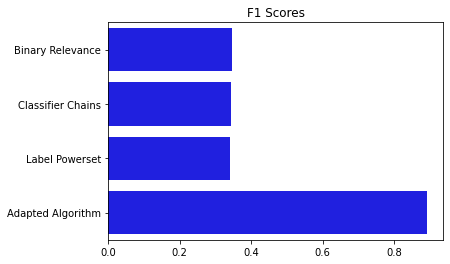

In [63]:
sns.barplot(F1, model_names, color="b")
plt.title('F1 Scores')
plt.show()

- The Binary Relevance, Classifier Chains, and Label Powerset only reached about 34% F1 score, most likely since they do not not consider label correlation since it treats every target variable independently.
- The Adapted Algorithm model allows an algorithm to directly perform the multi-label classification by implementing a K-Nearest Neighbor algorithm which resulted in an F1 score of 89%.